# PART 1 - OpenCV

In [43]:
import os
import cv2

import numpy as np
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import zipfile

In [44]:
# !kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
# !unzip brain-mri-images-for-brain-tumor-detection.zip -d ./input/

# Download the dataset
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

# Unzip the dataset using zipfile module
with zipfile.ZipFile('brain-mri-images-for-brain-tumor-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('./input/')


/usr/bin/bash: /home/devcontainers/miniconda3/envs/work/lib/python3.11/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /usr/bin/bash)
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [45]:
tumour_images=[]
for name in glob.glob('./input/brain_tumor_dataset/yes/*.jpg'): 
    image = cv2.imread(name)
    image = cv2.resize(image,(240,240))
    tumour_images.append(image)

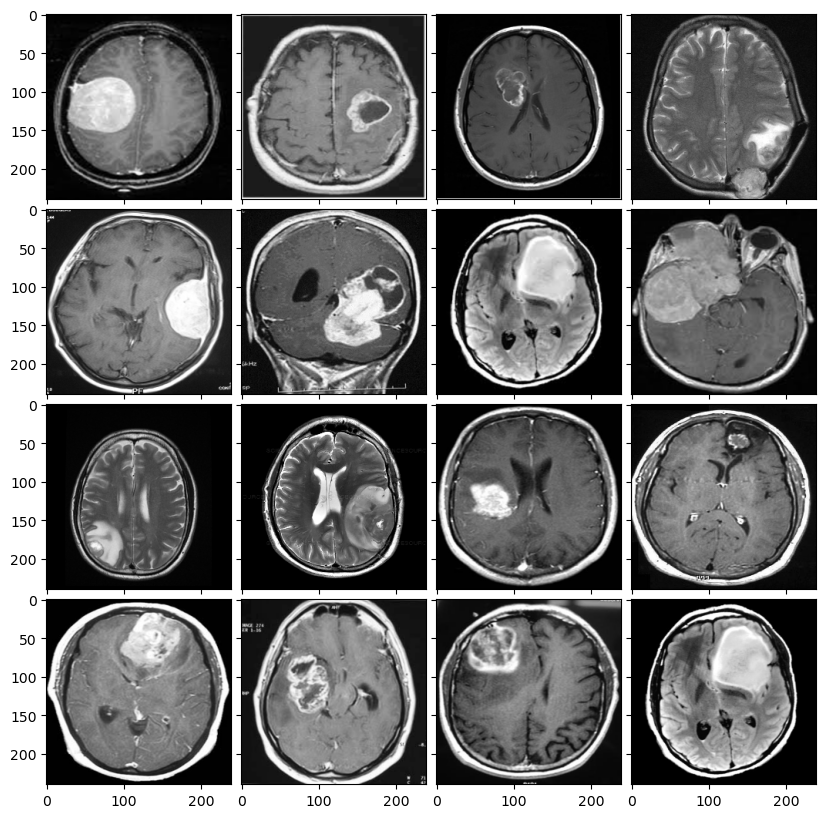

In [46]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4),  axes_pad=0.1,   )
for ax, im in zip(grid, tumour_images[0:16]):
    ax.imshow(im)
plt.show()

In [47]:
img_path = "./input/brain_tumor_dataset/yes/Y104.jpg"
image = cv2.imread(img_path)
print("width: {} pixels".format(image.shape[1]))
print("height: {} pixels".format(image.shape[0]))
print("channels: {}".format(image.shape[2]))
dim=(500,590)
image=cv2.resize(image, dim)

width: 700 pixels
height: 890 pixels
channels: 3


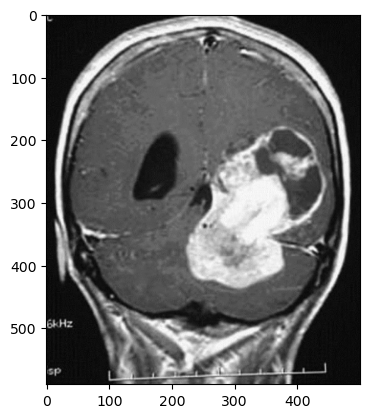

In [48]:
plt.imshow(image)

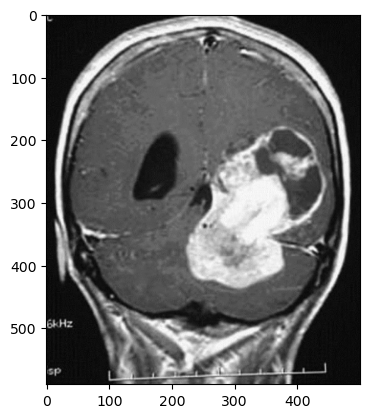

In [49]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY, 0.7)
plt.imshow(image)


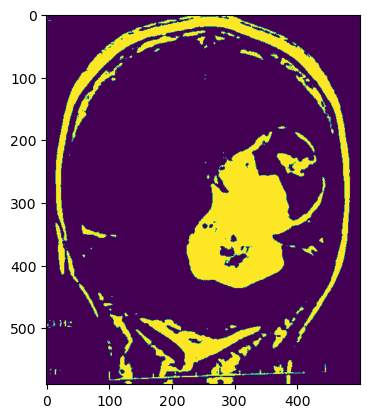

In [50]:
(T, thresh) = cv2.threshold(gray, 155, 255, cv2.THRESH_BINARY)
plt.imshow(thresh)


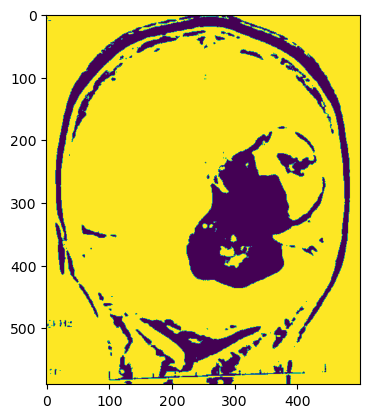

In [51]:
(T, threshInv) = cv2.threshold(gray, 155, 255, cv2.THRESH_BINARY_INV)
plt.imshow(threshInv)


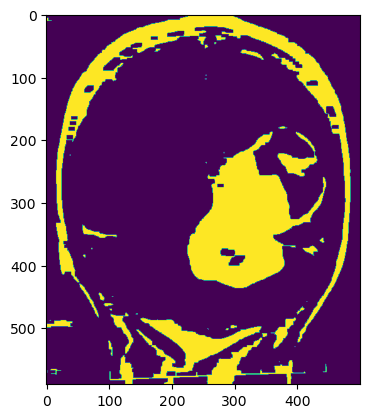

In [52]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 5))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
plt.imshow(closed)

In [53]:
closed = cv2.erode(closed, None, iterations = 19)
closed = cv2.dilate(closed, None, iterations = 17)

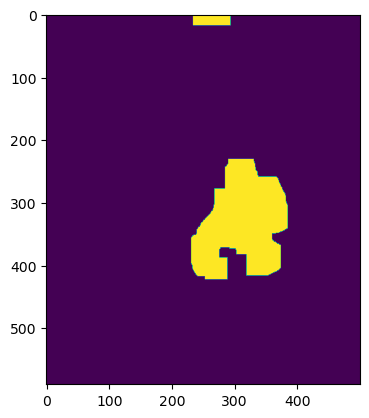

In [54]:
plt.imshow(closed)

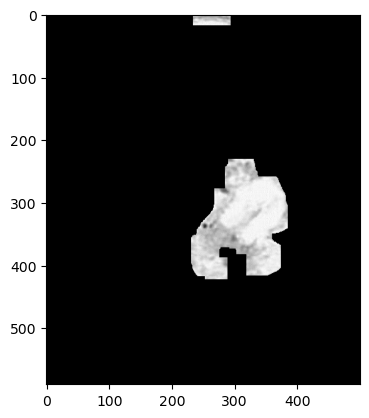

In [55]:
ret,mask = cv2.threshold(closed, 155, 255, cv2.THRESH_BINARY) 
#apply AND operation on image and mask generated by thrresholding
final = cv2.bitwise_and(image,image,mask = mask) 
plt.imshow(final)

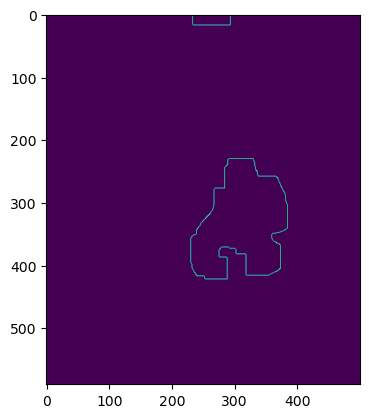

In [56]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged
canny = auto_canny(closed)
plt.imshow(canny)

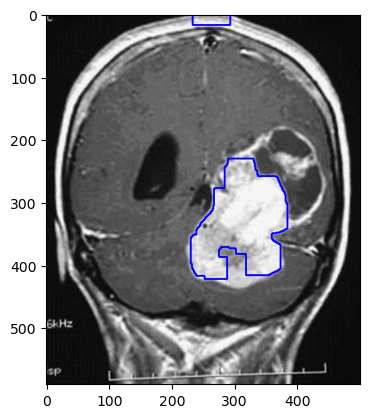

In [57]:
(cnts, _) = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL,
cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(image, cnts, -1, (0, 0, 255), 2)
plt.imshow(image) 

# Part 2 - FastAI

In [58]:
import numpy as np 
import pandas as pd 
import os,gc,pathlib
from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
from fastai.vision.models import *
print(os.listdir("./input"))
import torchvision.models as models

['brain_tumor_dataset', 'models', 'no', 'yes']


In [59]:
DATA_DIR='./input/brain_tumor_dataset/'

In [60]:
os.listdir(f'{DATA_DIR}')

['models', 'no', 'yes']

In [61]:
from fastai.vision.all import *

batch_tfms = [
    *aug_transforms(
        size=224, 
        mult=1.0,
        do_flip=True,
        flip_vert=False,
        max_rotate= 10.0,
        min_zoom= 1.0,
        max_zoom= 1.0,
        max_lighting= 0.2,
        max_warp= 0.2,
        p_affine= 0.75,
        p_lighting= 0.75,
        xtra_tfms= None,
        mode='bilinear',
        pad_mode='reflection',
        align_corners=True,
        batch=False,
        min_scale=1.1,
        ), 
    Normalize.from_stats(*imagenet_stats)]

dls = ImageDataLoaders.from_folder(
    DATA_DIR, 
    train=".", 
    valid_pct=0.25,
    item_tfms=[Resize(224)],
    batch_tfms=batch_tfms,
    size=224, 
    bs=24, 
    num_workers=0)

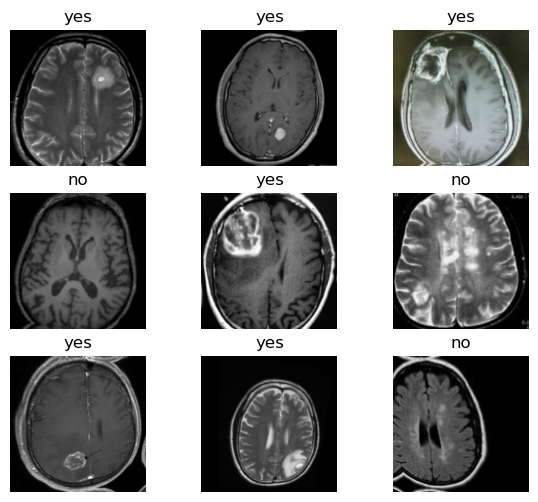

In [62]:
dls.show_batch(figsize=(7,6))

In [63]:
learner = vision_learner(
    dls,
    models.vgg19,
    metrics=accuracy
)

/home/devcontainers/miniconda3/envs/work/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/devcontainers/miniconda3/envs/work/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/home/devcontainers/miniconda3/envs/work/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_locati

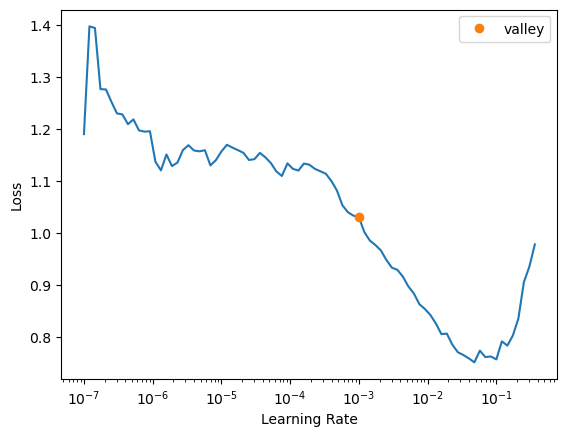

In [64]:
lr = learner.lr_find()


In [65]:
learner.fit_one_cycle(15,  lr.valley)

epoch,train_loss,valid_loss,accuracy,time
0,1.176628,0.901685,0.539683,01:21
1,1.089568,0.639206,0.666667,-1:58:44
2,0.993137,0.608265,0.746032,00:02
3,0.906504,0.555619,0.746032,00:02
4,0.798235,0.486021,0.809524,00:02
5,0.721375,0.489696,0.825397,00:02
6,0.646372,0.495320,0.825397,00:02
7,0.585255,0.515516,0.777778,01:22
8,0.541348,0.494268,0.777778,-1:58:45
9,0.493023,0.459969,0.809524,00:03


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

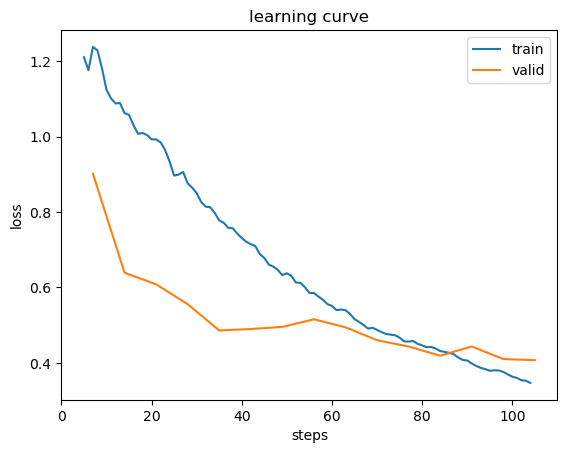

In [66]:
learner.recorder.plot_loss()

In [67]:
interp = ClassificationInterpretation.from_learner(learner)

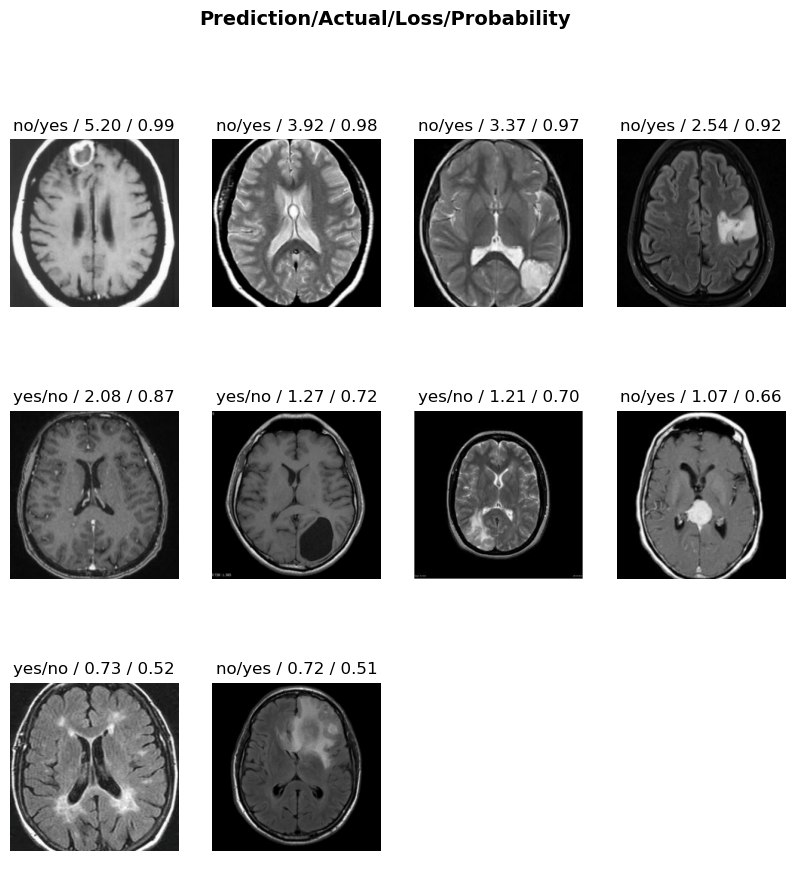

In [68]:
interp.plot_top_losses(10, figsize=(10,10))

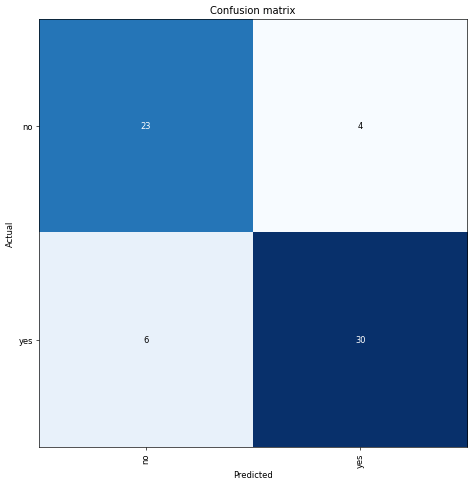

In [69]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [86]:
# Get the top losses
losses, idxs = interp.top_losses()

# Assuming the dataset has a method to retrieve the filenames
top_confused_files = [dls.valid_ds.items[i] for i in idxs]
print(top_confused_files)

[Path('input/brain_tumor_dataset/yes/Y85.JPG'), Path('input/brain_tumor_dataset/yes/Y117.JPG'), Path('input/brain_tumor_dataset/yes/Y249.JPG'), Path('input/brain_tumor_dataset/yes/Y50.JPG'), Path('input/brain_tumor_dataset/no/N20.JPG'), Path('input/brain_tumor_dataset/no/N11.jpg'), Path('input/brain_tumor_dataset/no/32 no.jpg'), Path('input/brain_tumor_dataset/yes/Y114.JPG'), Path('input/brain_tumor_dataset/no/23 no.jpg'), Path('input/brain_tumor_dataset/yes/Y24.jpg'), Path('input/brain_tumor_dataset/yes/Y160.JPG'), Path('input/brain_tumor_dataset/yes/Y257.jpg'), Path('input/brain_tumor_dataset/yes/Y66.JPG'), Path('input/brain_tumor_dataset/yes/Y100.JPG'), Path('input/brain_tumor_dataset/yes/Y18.JPG'), Path('input/brain_tumor_dataset/yes/Y91.jpg'), Path('input/brain_tumor_dataset/yes/Y116.JPG'), Path('input/brain_tumor_dataset/yes/Y78.jpg'), Path('input/brain_tumor_dataset/yes/Y35.jpg'), Path('input/brain_tumor_dataset/yes/Y29.jpg'), Path('input/brain_tumor_dataset/yes/Y26.jpg'), Path(

Confusion between yes and no occurred 3 times
Confusion between no and yes occurred 2 times


In [71]:
learner.unfreeze()

/home/devcontainers/miniconda3/envs/work/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_locati

SuggestedLRs(valley=4.365158383734524e-05)

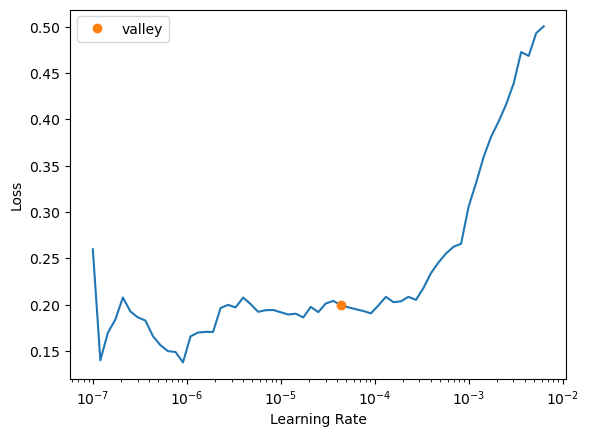

In [72]:
learner.lr_find()

In [73]:
learner.fit_one_cycle(15, 4.365158383734524e-05)

epoch,train_loss,valid_loss,accuracy,time
0,0.234792,0.426590,0.841270,-1:58:45
1,0.178553,0.463924,0.841270,00:03
2,0.192268,0.445071,0.809524,00:03
3,0.180944,0.561028,0.841270,00:03
4,0.173340,0.321663,0.888889,00:03
5,0.175757,0.602842,0.825397,01:22
6,0.178282,0.563310,0.809524,-1:58:45
7,0.167951,0.468023,0.841270,00:03
8,0.183000,0.327113,0.904762,00:03
9,0.163553,0.231755,0.920635,00:03


In [74]:
# learner.save('/kaggle/working/stage_2_1')

In [75]:
learner.fit_one_cycle(15, lr_max=slice(1e-06))

epoch,train_loss,valid_loss,accuracy,time
0,0.070806,0.225329,0.920635,00:03
1,0.063258,0.233524,0.920635,00:03
2,0.059940,0.223474,0.920635,00:03
3,0.057073,0.211404,0.920635,00:03
4,0.062112,0.219610,0.920635,00:03
5,0.064216,0.232848,0.920635,01:22
6,0.072607,0.228944,0.920635,-1:58:45
7,0.069638,0.220799,0.920635,00:03
8,0.080849,0.225489,0.920635,00:03
9,0.070819,0.224663,0.920635,00:03


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

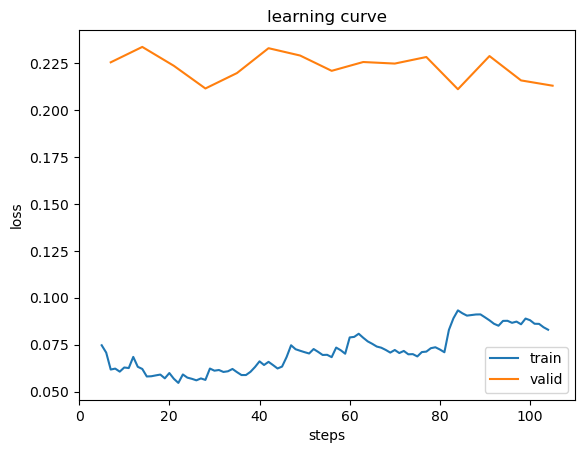

In [76]:
learner.recorder.plot_loss()

In [77]:
# learner.save('/kaggle/working/stage_2_2')

In [78]:
learner.fit_one_cycle(15, max_lr=slice(1e-04))

TypeError: Learner.fit_one_cycle() got an unexpected keyword argument 'max_lr'

In [33]:
learner.save('/kaggle/working/stage_2_3')

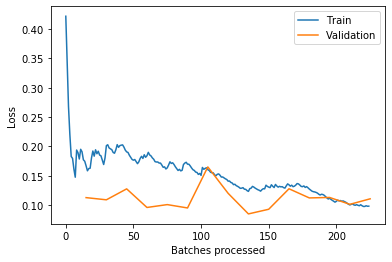

In [34]:
learner.recorder.plot_losses()

In [35]:
interp = ClassificationInterpretation.from_learner(learner)

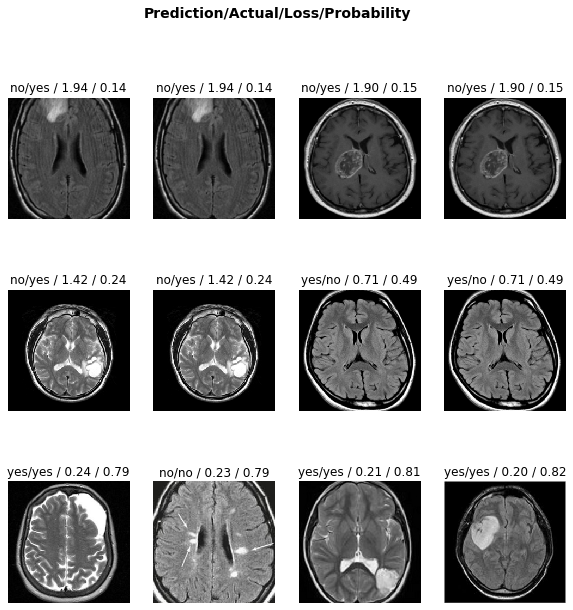

In [37]:
interp.plot_top_losses(12, figsize=(10,10))

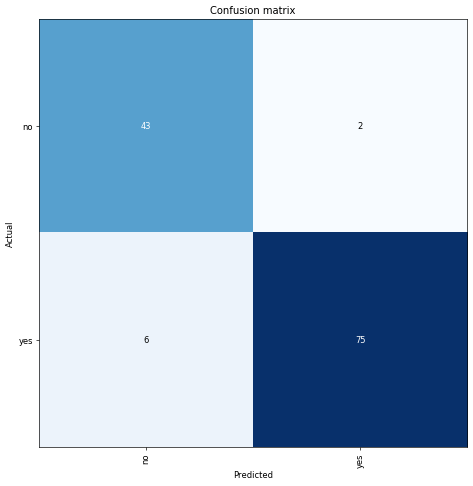

In [38]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)